In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.x13 import x13_arima_analysis, x13_arima_select_order
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [73]:
df = pd.read_csv("../data/raw_data.csv").rename(columns = {"DATE": "date", "Hard coal consumption per capita [tones]": "consumption"})
df.date = pd.to_datetime(df.date).dt.date

df

,date,consumption
0,1994-07-01,0.076
1,1994-08-01,0.097
2,1994-09-01,0.140
3,1994-10-01,0.213
4,1994-11-01,0.345
...,...,...
313,2020-08-01,0.005
314,2020-09-01,0.009
315,2020-10-01,0.028
316,2020-11-01,0.081


<AxesSubplot:title={'center':'Hard coal consumption per capita [tones]'}, xlabel='date'>

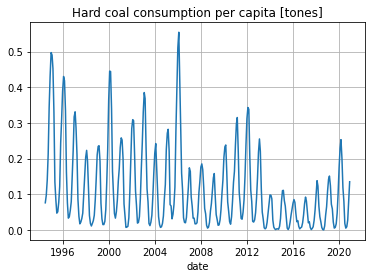

In [35]:
df.plot(x = "date", legend = False, title = "Hard coal consumption per capita [tones]", grid = True)

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


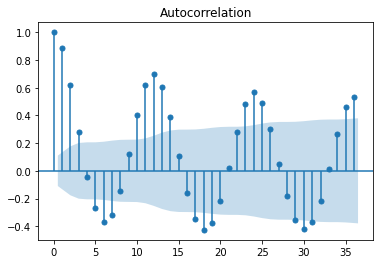

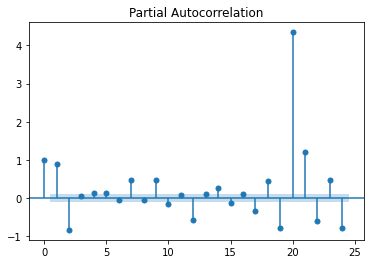

In [38]:
plot_acf(df.consumption, lags=36, alpha=.05, use_vlines=True)
plot_pacf(df.consumption, lags=24, alpha=.05, use_vlines=True)
print()

In [47]:
_, lbox_pval = acorr_ljungbox(df.consumption, lags=12)
lbox_pval < .05


/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [62]:
print(kpss(df.consumption)[1])
print(kpss(df.consumption.diff()[1:])[1])
adfuller(df.consumption)[1]

0.01
0.1


/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of 

0.012434602908348781

<AxesSubplot:title={'center':'Hard coal consumption per capita [tones]'}, xlabel='date'>

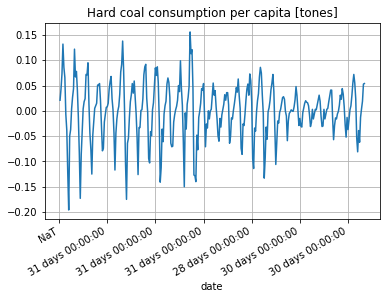

In [63]:
df.diff().plot(x = "date", legend = False, title = "Hard coal consumption per capita [tones]", grid = True)

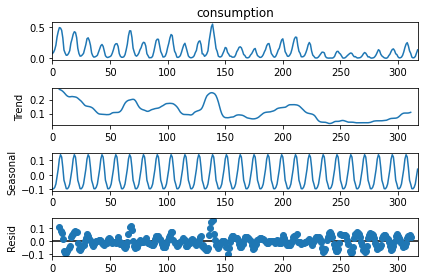

In [90]:
season_decomp_add = seasonal_decompose(df.consumption, model="additive", period=12)
season_decomp_add.plot()
print()

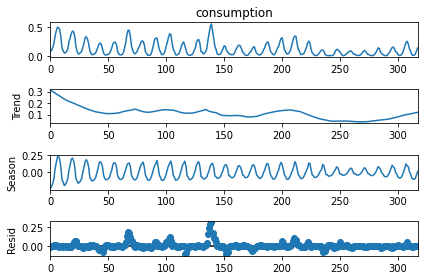

In [91]:
stl_decomp = STL(df.consumption, period=12, seasonal=7, robust=True).fit()
stl_decomp.plot()
print()

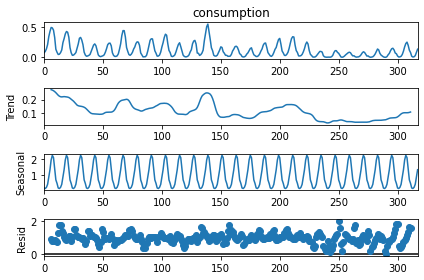

In [92]:
season_decomp_multi = seasonal_decompose(df.consumption + .0001, model="multiplicative", period=12)
season_decomp_multi.plot()
print()


In [110]:
seasonally_adjusted_data = pd.Series(
    (season_decomp_add.trend + season_decomp_add.resid).to_numpy(),
    index=df.date.values
)

df["seasonally_adjusted"] = seasonally_adjusted_data.to_numpy()
seasonally_adjusted_data = seasonally_adjusted_data.dropna()

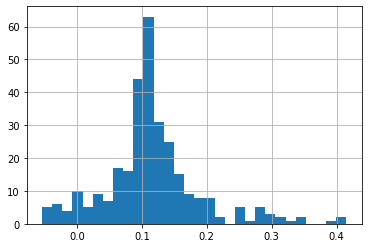

In [111]:
plt.hist(seasonally_adjusted_data.to_numpy(), bins=30)
plt.grid(True)

In [112]:
qmin, qmax = np.quantile(seasonally_adjusted_data.to_numpy(), q=[.05, .95])

df["outlier"] = (df.consumption.values < qmin) | (df.consumption.values > qmax)

df


,date,consumption,outlier,seasonally_adjusted
0,1994-07-01,0.076,False,NaN
1,1994-08-01,0.097,False,NaN
2,1994-09-01,0.140,False,NaN
3,1994-10-01,0.213,False,NaN
4,1994-11-01,0.345,True,NaN
...,...,...,...,...
313,2020-08-01,0.005,False,NaN
314,2020-09-01,0.009,False,NaN
315,2020-10-01,0.028,False,NaN
316,2020-11-01,0.081,False,NaN


In [ ]:
df.to_csv("../data/data_with_task1_results.csv")